This example shows how the interpolator prediction compares to a simulation randomly chosen from the training set.

Wavelength interpolation is for CFHT (1451 nm) based off http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=CFHT/CFHT.cfh8105&&mode=search&search_text=CFHT/CFHT.cfh8105#filter

Another one F182M added with an effective wavelength of 1839 nm, lies between H and K bands (http://svo2.cab.inta-csic.es/theory/fps/index.php?id=JWST/NIRCam.F182M&&mode=search&search_text=JWST/NIRCam.F182M#filter)

In [1]:
import os, sys, glob
os.environ["OMP_NUM_THREADS"] = "12"
import numpy as np
import save_sklearn_gp as ssg
from natsort import natsorted

# loading all the models from the family trained using a pole-on viewing angle

files = glob.glob('surrogate_data/2021_Wollaeger_TorusPeanutWind1/theta00deg/*')
files = natsorted(files) # sorting is necessary! otherwise time will be out of order

# Model: Wind Morphology ,  Composition ,  StatusL ,  Name
#          Peanut         Wind1         trained   2021_Wollaeger_TorusPeanutWind1
#          Peanut         Wind2         trained   2021_Wollaeger_TorusPeanut
#          Spherical      Wind1         trained   2021_Wollaeger_TorusSphericalWind1
#          Spherical      Wind2         trained   2021_Wollaeger_TorusSphericalWind2

# AK: model_X.dat columns: Dynamical mass (M0), dynamical vel (c), wind mass, wind velocity, wavelength (nm).
# AK: model_Y.dat columns: Light curve data

x_train = np.loadtxt(files[-1]+'/model_X.dat') # all files do NOT have the same X training data, but loading from the last one ensures that the previous interpolators will include that event
print('x_train.shape[0]', x_train.shape[0])   # 4050 = 450x9
print('x_train.shape', x_train.shape)         # (4050, 9) ## 9 bands
idx = np.random.randint(x_train.shape[0]) # randomly choose one of the events in the training set
print('idx',idx)                             #random number between 0 to 4050
inputs = x_train[None, idx]
print('inputs',inputs)                      # changeable input parameters, wavelenghts.
print(inputs[0][4])

inputs[0][0] = 0.014248
inputs[0][1] = 0.183263
inputs[0][2] = 0.085009
inputs[0][3] = 0.052937
inputs[0][4] = 1451        # 552, 673, 1451, 1839(mean)
print('inputs',inputs)
# loop through all the individual time steps, making a prediction at each

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
    
	x_train = np.loadtxt(file+'/model_X.dat') # size of training set changes at later times (not all sims go out to same time)
	idx = np.argmin([np.sum(np.abs(x_train[idx, :]-inputs[0, :])) for idx in range(x_train.shape[0])]) # finds index for inputs
	sim = np.loadtxt(file+'/model_y.dat')[idx] # above line identifies new index for event due to changing size of training set
	sim *= model._y_train_std #
	sim += model._y_train_mean
    
#	pred, err = ssg.predict(model, inputs)
	pred, err = ssg.predict(model, inputs, output = 'mags')
    
	try:
		lc_cfht = np.append(lc_cfht, pred)
		sim_lc_cfht = np.append(sim_lc_cfht, sim)
		errs_cfht = np.append(errs_cfht, err)
	except NameError:
		lc_cfht = pred # if first time point, initializes the light curve array
		sim_lc_cfht = sim
		errs_cfht = err # same as above, but for errors

x_train.shape[0] 4050
x_train.shape (4050, 5)
idx 111
inputs [[1.34600e-03 2.13617e-01 7.05740e-02 2.94807e-01 9.00000e+02]]
900.0
inputs [[1.42480e-02 1.83263e-01 8.50090e-02 5.29370e-02 1.45100e+03]]


In [2]:
inputs[0][0] = 0.014248
inputs[0][1] = 0.183263
inputs[0][2] = 0.085009
inputs[0][3] = 0.052937
inputs[0][4] = 1839        # 552, 673, 1451, 1839(mean)
print('inputs',inputs)
# loop through all the individual time steps, making a prediction at each

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
    
	x_train = np.loadtxt(file+'/model_X.dat') # size of training set changes at later times (not all sims go out to same time)
	idx = np.argmin([np.sum(np.abs(x_train[idx, :]-inputs[0, :])) for idx in range(x_train.shape[0])]) # finds index for inputs
	sim = np.loadtxt(file+'/model_y.dat')[idx] # above line identifies new index for event due to changing size of training set
	sim *= model._y_train_std #
	sim += model._y_train_mean
    
#	pred, err = ssg.predict(model, inputs)
	pred, err = ssg.predict(model, inputs, output = 'mags')
    
	try:
		lc_f182m = np.append(lc_f182m, pred)
		sim_lc_f182m = np.append(sim_lc_f182m, sim)
		errs_f182m = np.append(errs_f182m, err)
	except NameError:
		lc_f182m = pred # if first time point, initializes the light curve array
		sim_lc_f182m = sim
		errs_f182m = err # same as above, but for errors

inputs [[1.42480e-02 1.83263e-01 8.50090e-02 5.29370e-02 1.83900e+03]]


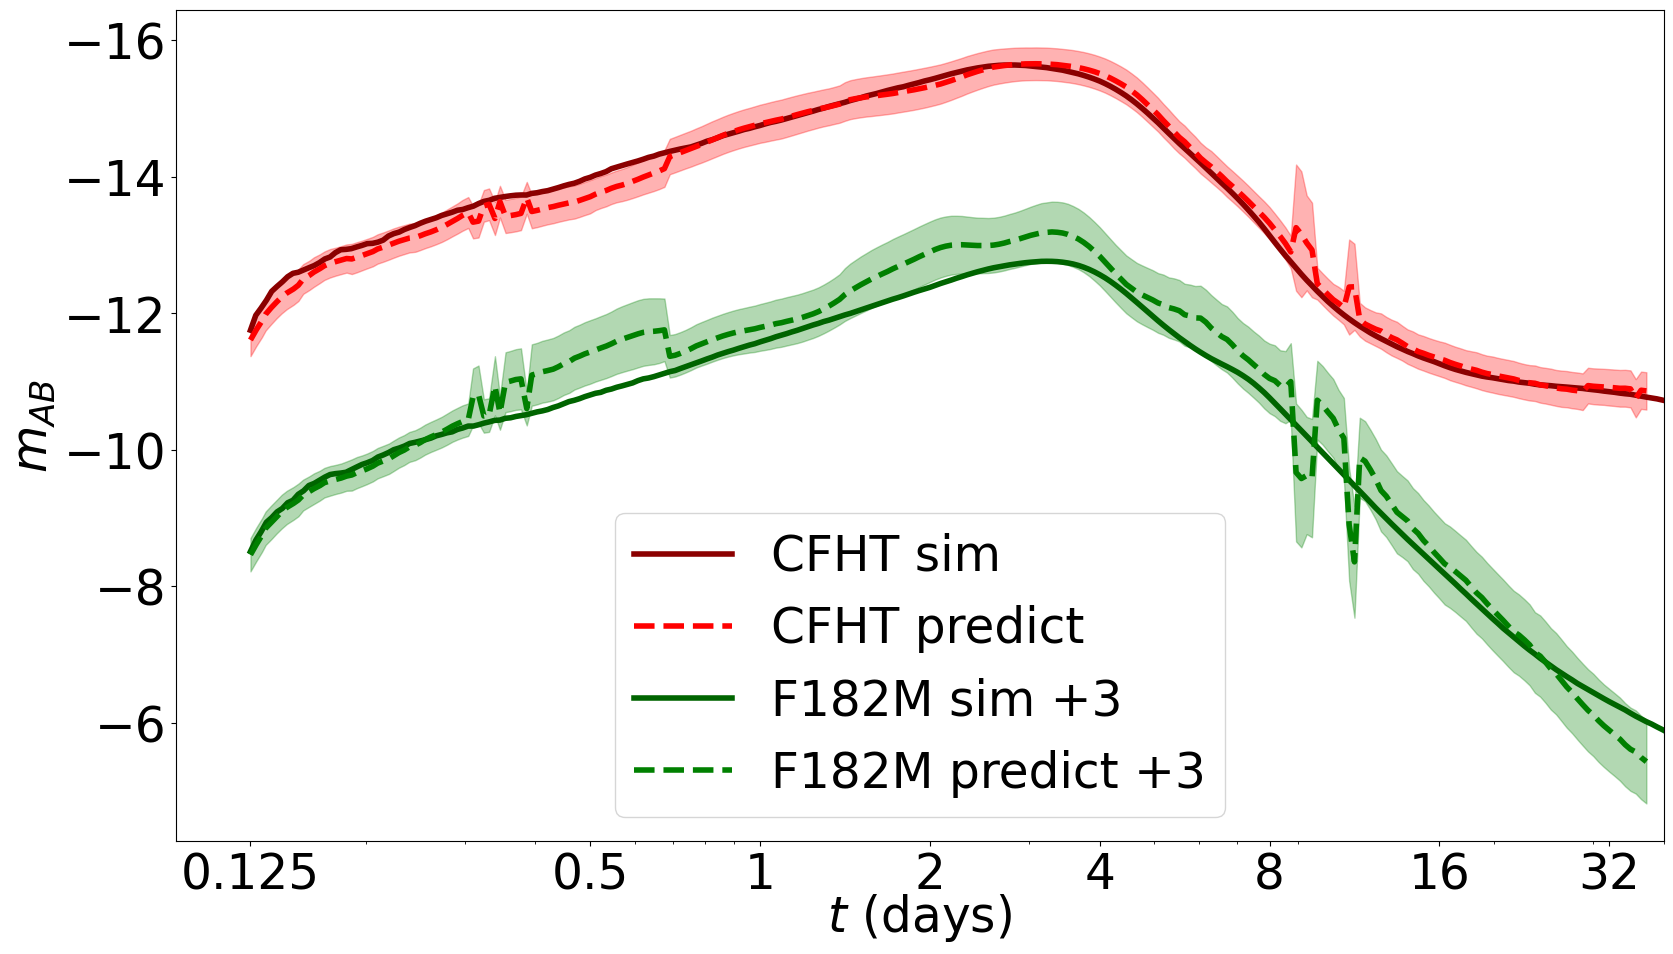

In [3]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import itertools

def flip(items, ncol):
    '''
    credit to Avaris on StackOverflow for this function
    '''
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

times = np.zeros(len(files))
for i in range(len(files)):
    times[i] = float(files[i][-10:-5])
    if float(times[i]) - float(times[i-1]) < 0:
        times[i] = float(files[i][-11:-5])
      # len(times) = len(lc)
#times = np.logspace(np.log10(0.125), np.log10(37.239195485411194), len(lc)) #AK: Check if these times are correct.

colors = {"g": "blue", "r": "cyan", "i": "lime", "z": "green", "y": "greenyellow", "J": "gold",
         "H": "orange", "K": "red", "S": "darkred"}
wavelengths = 'grizyJCHFKS'
plt.figure(figsize=(19.2, 10.8))
plt.rc('font', size = 35)
plt.rc('lines', lw=4)


file2 = np.loadtxt('luminosity_cfht.dat')
#plt.plot(file2[:,0],file2[:,1], label='simulation')      # Luminosity
r = 3.086e18 # parsec to cm
r *= 10 # 10 pc for absolute magnitude
flux = file2[:,1] - np.log10(4*np.pi*r**2)
mags = -48.6 - 2.5*flux
plt.plot(file2[:,0],mags, label='CFHT sim', color='darkred')             # Abs Mag


plt.plot(times, lc_cfht, label='CFHT predict', color='red', linestyle='dashed')#, color=colors[wavelengths[band]], label=wavelengths[band])
plt.fill_between(times, lc_cfht-errs_cfht, lc_cfht+errs_cfht, alpha=0.3, color='red')#, color=colors[wavelengths[band]], alpha=0.3)
plt.xscale('log')
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))


file2 = np.loadtxt('luminosity_f182m.dat')
#plt.plot(file2[:,0],file2[:,1], label='simulation')      # Luminosity
r = 3.086e18 # parsec to cm
r *= 10 # 10 pc for absolute magnitude
flux = file2[:,1] - np.log10(4*np.pi*r**2)
mags = -48.6 - 2.5*flux
plt.plot(file2[:,0],mags+3, label='F182M sim +3', color='darkgreen')             # Abs Mag

plt.plot(times, lc_f182m+3, label='F182M predict +3', color='green', linestyle='dashed')#, color=colors[wavelengths[band]], label=wavelengths[band])
plt.fill_between(times, lc_f182m-errs_f182m+3, lc_f182m+errs_f182m+3, alpha=0.3, color='green')#, color=colors[wavelengths[band]], alpha=0.3)
plt.xscale('log')
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8, 16, 32])
#plt.xlim([8, 16])
plt.gca().set_xlim(right=40)
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.xlabel(r"$t$ (days)", labelpad=-5)
plt.ylabel(r"$m_{AB}$")
plt.legend()
plt.gca().invert_yaxis()


plt.savefig('PeanutWind1.png', format='png')#, transparent=False)